In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

from pathlib import Path
import pickle
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils
from sklearn.manifold import TSNE

from stylegan2.training.dataset import ImageFolderDataset
import stylegan2.dnnlib
import stylegan2.legacy
from models import CNN_MNIST

for p in [
    Path('/d/alecoz/projects'), # DeepLab
    Path(os.path.expandvars('$WORK')), # Jean Zay
    Path('w:/')]: # local
    if os.path.exists(p):
        path_main = p
path_results = path_main / 'uncertainty-conditioned-gan/results'
path_data = path_main / 'DATA'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)

/tmp/ipykernel_1629233/4127631385.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


cuda:0


In [2]:
# class_selected = 9
class_selected = 'all'

In [3]:
# # CLEAN DATA
# # path_model = path_results/ 'stylegan2-training-runs' / '00003-mnist_stylegan2-cond-cifar'
# path_model = path_results/ 'stylegan2-training-runs' / '00005-mnist_stylegan2-cond-cifar-classifCond' # classifCond
# path_classifier = path_results / 'classifiers' / 'CNN_mnist_clean_20230525_1119.pth'
# dataset_train = 'mnist_stylegan2'
# dataset_test = 'mnistTest_stylegan2'

# DATA CORRUPTED
path_model = path_results / 'stylegan2-training-runs' / '00006-mnist_stylegan2_blur_noise_maxSeverity5_proba50-cond-cifar-classifCond'
path_classifier = path_results / 'classifiers' / 'CNN_mnist_stylegan2_blur_noise_maxSeverity5_proba50_20230525_1124.pth'
dataset_train = 'mnist_stylegan2_blur_noise_maxSeverity5_proba50'
dataset_test = 'mnistTest_stylegan2_blur_noise_maxSeverity5_proba50'

# # DATA CORRUPTED (MORE)
# path_model = path_results / 'stylegan2-training-runs' / '00007-mnist_stylegan2_blur_noise_maxSeverity5_proba100-cond-cifar-classifCond'
# path_classifier = path_results / 'classifiers' / 'CNN_mnist_stylegan2_blur_noise_maxSeverity5_proba100_20230525_1128.pth'
# dataset_train = 'mnist_stylegan2_blur_noise_maxSeverity5_proba100'
# dataset_test = 'mnistTest_stylegan2_blur_noise_maxSeverity5_proba100'

n_classes = 10

In [4]:
def postprocess_images(images):
    assert images.dim() == 4, "Expected 4D (B x C x H x W) image tensor, got {}D".format(images.dim())
    images = ((images + 1) / 2).clamp(0, 1) # scale
    images = images[:, :, 2:30, 2:30] # remove padding
    return images

def plot_images_grid(images, title=''):
    images = images * 255
    images = images.to(torch.uint8)
    plt.figure()
    plt.imshow(vutils.make_grid(images.cpu(), pad_value=255).permute(1,2,0), vmin=0, vmax=255)
    plt.axis('off')
    plt.grid(False)
    plt.title(title)
    
def generate_random_images(n_images=5):
    z = torch.randn((n_images, G.z_dim), device=device)
    labels = torch.randint(0, n_classes, (n_images,), device=device)
    c = F.one_hot(labels, n_classes)
    ws = G.mapping(z, c, truncation_psi=1)
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)
    img = postprocess_images(img)
    return img

def get_classifier_MSP(logits):
    max_softmax_proba = torch.max(torch.softmax(logits, axis=1), axis=1).values
    return max_softmax_proba

def get_classifier_TCP(logits, labels):
    y_as_idx = F.one_hot(labels.long(), num_classes=10).bool()
    probas = torch.softmax(logits, dim=1)
    true_class_proba = probas[y_as_idx]
    return true_class_proba

def mahalanobis(U, v):
    ''' Compute the Mahalanobis distance between each row of U and v'''
    cov_inv = torch.linalg.inv(torch.cov(U.T))
    m = torch.zeros(U.shape[0])
    for i in range(U.shape[0]):
        delta = U[i, :] - v
        m[i] = torch.sqrt(torch.matmul(torch.matmul(delta, cov_inv), delta.T))
    return m

In [5]:
# LOAD GENERATOR
if not str(path_model).endswith('pkl'):
    # find best model in folder
    with open(path_model / 'metric-fid50k_full.jsonl', 'r') as json_file:
        json_list = list(json_file)
    best_fid = 1e6
    for json_str in json_list:
        json_line = json.loads(json_str)
        if json_line['results']['fid50k_full'] < best_fid:
            best_fid = json_line['results']['fid50k_full']
            best_model = json_line['snapshot_pkl']
    print('Best FID: {:.2f} ; best model : {}'.format(best_fid, best_model))
    path_model = path_model / best_model
    with open(path_model, 'rb') as f:
        G = pickle.load(f)['G_ema'].eval().to(device)  # torch.nn.Module
else:
    with dnnlib.util.open_url(path_model) as f:
        G = legacy.load_network_pkl(f)['G_ema'].eval().requires_grad_(False).to(device)
        

# LOAD CLASSIFIER
classifier = CNN_MNIST()
classifier.load_state_dict(torch.load(path_classifier, map_location=device))
classifier = classifier.eval().requires_grad_(False).to(device)


# LOAD DATASET
path_dataset = path_data / 'MNIST' / f'{dataset_train}.zip'
train_data = ImageFolderDataset(path_dataset, use_labels=True)
train_dataloader = DataLoader(train_data, batch_size=128)

path_dataset = path_data / 'MNIST' / f'{dataset_test}.zip'
test_data = ImageFolderDataset(path_dataset, use_labels=True)
test_dataloader = DataLoader(test_data, batch_size=128)

Best FID: 16.30 ; best model : network-snapshot-005443.pkl


# Classifier

In [6]:
correct = 0
for x, y in train_dataloader:
    x = (x / 255)[:, :, 2:30, 2:30]
    y = y.argmax(1)
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        logits = classifier(x)
        pred = torch.max(logits, axis=1).indices
        correct += (pred == y).sum().item()
accuracy = correct / len(train_data)
print('Accuracy on training set: {:.2f}%'.format(accuracy * 100))

correct = 0
for x, y in test_dataloader:
    x = (x / 255)[:, :, 2:30, 2:30]
    y = y.argmax(1)
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        logits = classifier(x)
        pred = torch.max(logits, axis=1).indices
        correct += (pred == y).sum().item()
accuracy = correct / len(test_data)

print('Accuracy on test set: {:.2f}%'.format(accuracy * 100))

Accuracy on training set: 94.08%
Accuracy on test set: 93.25%


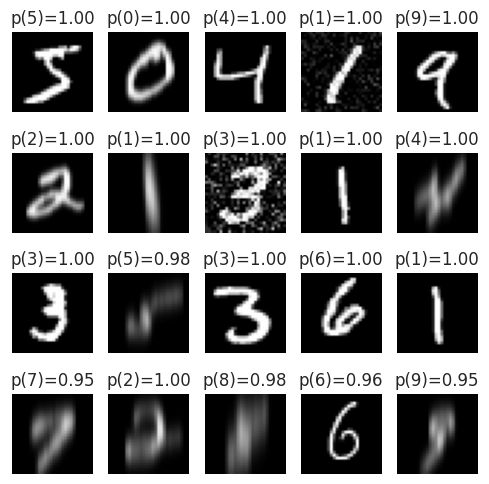

In [7]:
for x, y in train_dataloader:
    x = (x / 255)[:, :, 2:30, 2:30]
    y = y.argmax(1)
    x, y = x.to(device), y.to(device)
    break

fig, axs = plt.subplots(4, 5, figsize=(6, 6))
for i in range(20): # for each image
    ax = axs.flatten()[i]
    img = x[i]
    
    logits = classifier(img.unsqueeze(0))
    probas = torch.softmax(logits, axis=1)
    msp, class_pred = torch.max(probas, axis=1)
    
    ax.imshow(img.cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.grid(False)
    title = 'p({})={:.2f}'.format(class_pred.item(), msp.item())
    ax.set_title(title)
    
plt.savefig('results_mnist_data')

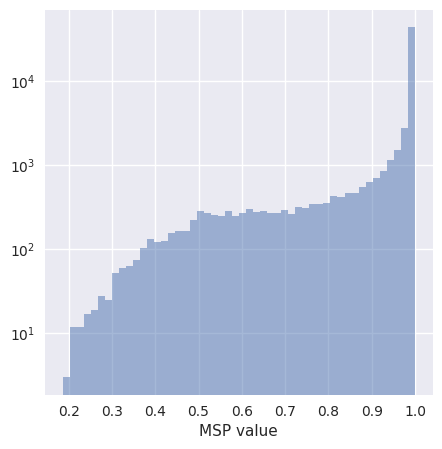

In [8]:
def get_MSP_TCP(dataloader, classifier, device):

    classifier.eval()
    msp = torch.zeros((len(dataloader.dataset)))
    tcp = torch.zeros((len(dataloader.dataset)))
    idx = 0
    for X, y in dataloader:
        batch_size = X.shape[0]

        X = (X / 255)[:, :, 2:30, 2:30]
        y = y.argmax(1)
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            logits = classifier(X)
        msp[idx:idx+batch_size] = get_classifier_MSP(logits)
        tcp[idx:idx+batch_size] = get_classifier_TCP(logits, y)
        idx += batch_size

    return msp, tcp



msp_train, tcp_train = get_MSP_TCP(train_dataloader, classifier, device)
# msp_test, tcp_test = get_MSP_TCP(test_dataloader, classifier, device)


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.set_xlabel('train')
# ax1.hist(msp_train, alpha=0.5, bins=50, label='MSP')
# ax1.hist(tcp_train, alpha=0.5, bins=50, label='TCP')
# ax1.legend()

# ax2.set_xlabel('test')
# ax2.hist(msp_test, alpha=0.5, bins=50, label='MSP')
# ax2.hist(tcp_test, alpha=0.5, bins=50, label='TCP')
# ax2.legend()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel('MSP value')
ax.hist(msp_train, alpha=0.5, bins=50, log=True)

plt.savefig('results_mnist_classifier_MSP')

tensor(1, device='cuda:0')
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')


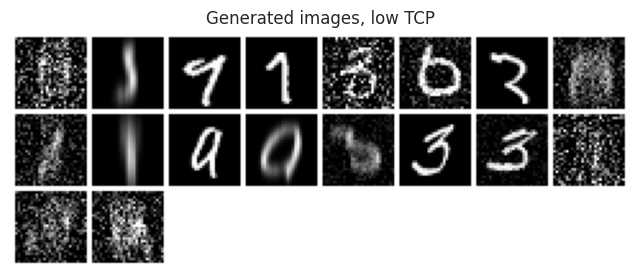

In [9]:
def get_images_low_TCP(dataloader, classifier, device, n_images):
    classifier.eval()
    images = torch.zeros((n_images, 1, 28, 28))
    idx = 0
    for X, y in dataloader:
        batch_size = X.shape[0]

        X = (X / 255)[:, :, 2:30, 2:30]
        y = y.argmax(1)
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            logits = classifier(X)
        tcp = get_classifier_TCP(logits, y)
        idx_low_tcp = tcp < 0.05
        n_images_low_tcp = idx_low_tcp.int().sum()
        print(n_images_low_tcp)
        if idx+n_images_low_tcp <= n_images:
            images[idx:idx+n_images_low_tcp] = X[idx_low_tcp]
            idx += n_images_low_tcp
        else:
            images[idx:] = X[idx_low_tcp][:n_images - (idx+n_images_low_tcp)]
            break
 
    return images


img = get_images_low_TCP(train_dataloader, classifier, device, 18)

plot_images_grid(img, title=f'Generated images, low TCP')


# Generator

In [10]:
# img = generate_random_images(n_images=5)
# plot_images_grid(img, title='Generated images')

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


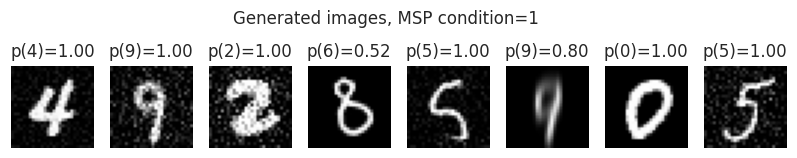

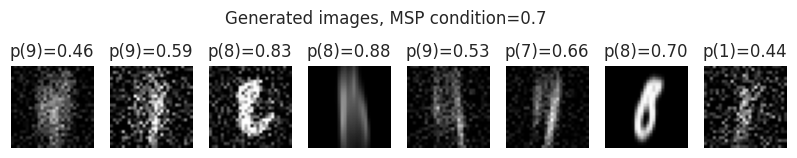

In [11]:
if G.c_dim == 11:
    n_images = 8

    z = torch.randn((n_images, G.z_dim), device=device)
    if class_selected == 'all':
        labels = torch.randint(0, n_classes, (n_images,), device=device)
    else:
        labels = class_selected * torch.ones((n_images,), dtype=torch.int64, device=device)
    c_labels = F.one_hot(labels, n_classes)
    c_classif = torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)

    ws = G.mapping(z, c, truncation_psi=1)
    imgs = G.synthesis(ws, noise_mode='const', force_fp32=True)
    imgs = postprocess_images(imgs)
    
    # plot
    fig, axs = plt.subplots(1, 8, figsize=(10, 2))
    fig.suptitle('Generated images, MSP condition=1')
    for i in range(8): # for each image
        ax = axs.flatten()[i]
        img = imgs[i]

        logits = classifier(img.unsqueeze(0))
        probas = torch.softmax(logits, axis=1)
        msp, class_pred = torch.max(probas, axis=1)

        ax.imshow(img.cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
        ax.axis('off')
        ax.grid(False)
        title = 'p({})={:.2f}'.format(class_pred.item(), msp.item())
        ax.set_title(title)
    plt.savefig('results_mnist_generator_confid1')

    # change only classif condition
    proba = 0.7
    c_classif = proba * torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)
    
    ws = G.mapping(z, c, truncation_psi=1)
    imgs = G.synthesis(ws, noise_mode='const', force_fp32=True)
    imgs = postprocess_images(imgs)
    
    # plot
    fig, axs = plt.subplots(1, 8, figsize=(10, 2))
    fig.suptitle('Generated images, MSP condition=0.7')
    for i in range(8): # for each image
        ax = axs.flatten()[i]
        img = imgs[i]

        logits = classifier(img.unsqueeze(0))
        probas = torch.softmax(logits, axis=1)
        msp, class_pred = torch.max(probas, axis=1)

        ax.imshow(img.cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
        ax.axis('off')
        ax.grid(False)
        title = 'p({})={:.2f}'.format(class_pred.item(), msp.item())
        ax.set_title(title)
    plt.savefig('results_mnist_generator_confid07')


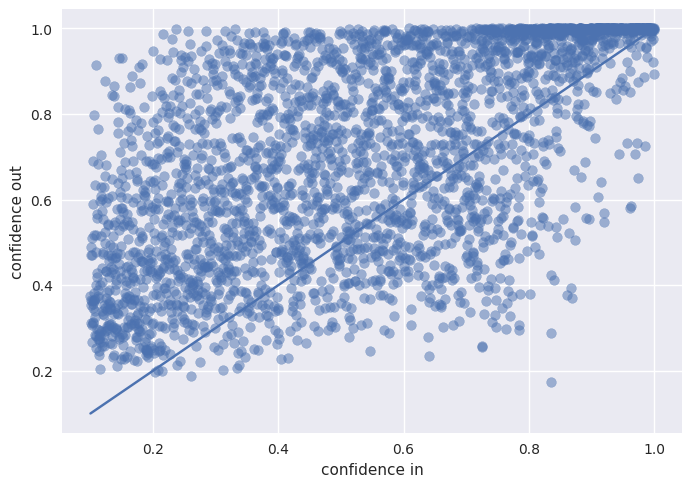

In [12]:
if G.c_dim == 11:
    n_images = 3000
    
    if class_selected == 'all':
        labels = torch.randint(0, n_classes, (n_images,), device=device)
    else:
        labels = class_selected * torch.ones((n_images,), dtype=torch.int64, device=device)
    c_labels = F.one_hot(labels, n_classes)
    # uniform confidence
    confid_in = torch.linspace(0.1, 1, n_images, device=device).unsqueeze(1)
    c = torch.cat((c_labels, confid_in), dim=1)
    
    confid_out = torch.empty(0, device=device)
    for c_i in DataLoader(c, 100):
        z = torch.randn((c_i.shape[0], G.z_dim), device=device)

        ws = G.mapping(z, c_i, truncation_psi=1)
        img = G.synthesis(ws, noise_mode='const', force_fp32=True)
        img = postprocess_images(img)
        confid_out = torch.cat((confid_out, F.softmax(classifier(img), dim=1).max(dim=1).values))

    plt.figure()
    plt.plot([0.1, 1], [0.1, 1])
    plt.scatter(confid_in.cpu(), confid_out.cpu(), alpha=0.5)
    plt.xlabel('confidence in')
    plt.ylabel('confidence out')
    
    plt.savefig('results_mnist_generator_MSP')

# MSP direction in W

tester ajouter direction seulement a w_7 ou w_8

In [ ]:
if G.c_dim == 11:
    n_images = 10000
    confidence_max = 1
    confidence_min = 0.9

    z = torch.randn((n_images, G.z_dim), device=device)
    if class_selected == 'all':
        labels = torch.randint(0, n_classes, (n_images,), device=device)
    else:
        labels = class_selected * torch.ones((n_images,), dtype=torch.int64, device=device)
    c_labels = F.one_hot(labels, n_classes)
    c_classif = confidence_max*torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)
    w_max = G.mapping(z, c, truncation_psi=1)[:,0,:].mean(dim=0)

    # WITH NEW Z
    # z = torch.randn((n_images, G.z_dim), device=device)
    # labels = torch.randint(0, n_classes, (n_images,), device=device)
    # c_labels = F.one_hot(labels, n_classes)
    # c_classif = confidence_min*torch.ones((n_images, 1), device=device)
    # c = torch.cat((c_labels, c_classif), dim=1)
    # w_min = G.mapping(z, c, truncation_psi=1)[:,0,:].mean(dim=0)

    # WITHOUT NEW Z
    c_classif = confidence_min*torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)
    w_min = G.mapping(z, c, truncation_psi=1)[:,0,:].mean(dim=0)

    w_dir_msp = (w_max - w_min)

In [ ]:
if G.c_dim == 11:
    n_images = 8
    lambda_ = 2

    z = torch.randn((n_images, G.z_dim), device=device)
    if class_selected == 'all':
        labels = torch.randint(0, n_classes, (n_images,), device=device)
    else:
        labels = class_selected * torch.ones((n_images,), dtype=torch.int64, device=device)
    c_labels = F.one_hot(labels, n_classes)
    c_classif = torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)

    ws = G.mapping(z, c, truncation_psi=1)
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)
    img = postprocess_images(img)
    plot_images_grid(img, title='Generated images, confidence=1')
    plt.show()
    print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)

    # move along w_dir_msp

    ws_moved = ws - lambda_ * w_dir_msp
    img = G.synthesis(ws_moved, noise_mode='const', force_fp32=True)
    img = postprocess_images(img)
    plot_images_grid(img, title=f'Generated images, edited along w_dir_msp')
    plt.show()
    print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)

# Generate data

In [ ]:
def classify_from_ws(ws, labels=None):
    dataloader = DataLoader(TensorDataset(ws, labels), 128)
    msp = torch.empty(ws.shape[0])
    tcp = torch.empty(ws.shape[0])
    idx_batch = 0
    for ws_, y in dataloader:
        batch_size = ws_.shape[0]
        img = G.synthesis(ws_, noise_mode='const')
        img = postprocess_images(img)
        logits = classifier(img)
        msp[idx_batch:idx_batch+batch_size] = get_classifier_MSP(logits).cpu()
        tcp[idx_batch:idx_batch+batch_size] = get_classifier_TCP(logits, y).cpu()
        idx_batch += batch_size
    well_classified = msp == tcp
    return msp, tcp, well_classified

In [ ]:
# TRAIN
if class_selected == 'all':
    n_images_train = 60000
    labels_train = torch.randint(0, n_classes, (n_images_train,), device=device)
else:
    n_images_train = 60000
    labels_train = class_selected * torch.ones((n_images_train,), dtype=torch.int64, device=device)
z_train = torch.randn((n_images_train, G.z_dim), device=device)
c_labels_train = F.one_hot(labels_train, n_classes)
if G.c_dim == 11:
    c_classif_train = 0.8 + 0.2 * torch.rand((n_images_train, 1), device=device)
    c_train = torch.cat((c_labels_train, c_classif_train), dim=1)
elif G.c_dim == 10:
    c_train = c_labels_train

ws_train = G.mapping(z_train, c_train, truncation_psi=1)
w_train = ws_train[:, 0, :]
msp_train, tcp_train, well_classified_train = classify_from_ws(ws_train, labels_train)

# VAL
if class_selected == 'all':
    n_images_val = 10000
    labels_val = torch.randint(0, n_classes, (n_images_val,), device=device)
else:
    n_images_val = 10000
    labels_val = class_selected * torch.ones((n_images_val,), dtype=torch.int64, device=device)
z_val = torch.randn((n_images_val, G.z_dim), device=device)
c_labels_val = F.one_hot(labels_val, n_classes)
if G.c_dim == 11:
    c_classif_val = 0.8 + 0.2 * torch.rand((n_images_val, 1), device=device)
    c_val = torch.cat((c_labels_val, c_classif_val), dim=1)
elif G.c_dim == 10:
    c_val = c_labels_val

ws_val = G.mapping(z_val, c_val, truncation_psi=1)
w_val = ws_val[:, 0, :]
msp_val, tcp_val, well_classified_val = classify_from_ws(ws_val, labels_val)


perfo_direction = (((w_train[well_classified_train.logical_not()] - w_train.mean(0)) / w_train.std(0)).mean(0)
                       - ((w_train[well_classified_train] - w_train.mean(0)) / w_train.std(0)).mean(0))


# t-SNE

In [ ]:
n_samples = 10000

w_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(w_train[:n_samples, :].cpu().numpy())

top_k = 10
top_k_dims = (-np.abs(perfo_direction.cpu())).argsort()[:top_k]
w_embedded_topk = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(w_train[:n_samples, top_k_dims].cpu().numpy())


fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i, w_emb in enumerate([w_embedded, w_embedded_topk]):
    sc0 = axs[0, i].scatter(w_emb[:, 0], w_emb[:, 1], c=well_classified_train[:n_samples].cpu(), alpha=0.2, cmap='viridis')
    sc1 = axs[1, i].scatter(w_emb[:, 0], w_emb[:, 1], c=msp_train[:n_samples].cpu(), alpha=0.2, cmap='viridis')
    if G.c_dim == 11:
        sc2 = axs[2, i].scatter(w_emb[:, 0], w_emb[:, 1], c=c_classif_train[:n_samples].cpu(), alpha=0.2, cmap='viridis')
        fig.colorbar(sc2, ax=axs[2, i], label='MSP input')
    fig.colorbar(sc0, ax=axs[0, i], label='well-classified')
    fig.colorbar(sc1, ax=axs[1, i], label='MSP')
fig.tight_layout()
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
axs[0, 0].set_title('W - All dimensions')
axs[0, 1].set_title(f'W - Top {top_k} dimensions')

# Domain defined by MSP inputidx_domain

In [ ]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = msp_train > cut
    coverage_baseline[i] = idx_domain.float().mean()
    acc_baseline[i] = well_classified_train[idx_domain].float().mean()
    
# msp input of generator
domain_cutoff_mspIn = np.linspace(0, 1, 1000)
coverage_mspIn = np.zeros_like(domain_cutoff_mspIn)
acc_mspIn = np.zeros_like(domain_cutoff_mspIn)
for i, cut in enumerate(domain_cutoff_mspIn):
    idx_domain = c_classif_train.squeeze().cpu() > cut
    coverage_mspIn[i] = idx_domain.float().mean()
    acc_mspIn[i] = well_classified_train[idx_domain].float().mean()
    
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('coverage vs. accuracy')
ax.plot(coverage_baseline, acc_baseline, c='k', label='baseline (max softmax)')
ax.plot(coverage_mspIn, acc_mspIn, label='MSP input of GAN')
ax.legend()
ax.set_xlabel('coverage')
ax.set_ylabel('accuracy')

# Domain as distance from MSP=1 center


In [ ]:
w_center_msp1 = w_train[(msp_train > 0.99), :].mean(dim=0, keepdims=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('coverage vs. accuracy (distance from MSP>0.99 center)')
ax1.set_title('cosine similarity')
ax2.set_title('euclidian distance')
ax3.set_title('Mahalanobis distance')

for top_k in [2, 10, 20, 30, 50, 100, 200, w_train.shape[-1]]:
    perfo_direction = (((w_train[well_classified_train.logical_not()] - w_train.mean(0)) / w_train.std(0)).mean(0)
                       - ((w_train[well_classified_train] - w_train.mean(0)) / w_train.std(0)).mean(0))
    top_k_dims = (-np.abs(perfo_direction.cpu())).argsort()[:top_k]

    mahalanobis_dist_train = mahalanobis(w_train[:, top_k_dims], w_center_msp1[:, top_k_dims])
    euclidian_dist_train = torch.cdist(w_train[:, top_k_dims], w_center_msp1[:, top_k_dims]).squeeze().cpu()
    cosine_sim_train = torch.nn.functional.cosine_similarity(w_train[:, top_k_dims], w_center_msp1[:, top_k_dims]).cpu()
    c_classif = c_classif.squeeze().cpu()

    # cosine similarity
    domain_cutoff_cosineSim = np.linspace(0, 1, 1000)
    coverage_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    acc_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    for i, cut in enumerate(domain_cutoff_cosineSim):
        idx_domain = cosine_sim_train > cut
        coverage_cosineSim[i] = idx_domain.float().mean()
        acc_cosineSim[i] = well_classified_train[idx_domain].float().mean()
    ax1.plot(coverage_cosineSim, acc_cosineSim, label=f'cosine similarity - top {top_k} dims')

    # euclidian distance
    domain_cutoff_eucliDist = np.linspace(0, 1, 1000)
    coverage_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    acc_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    for i, cut in enumerate(domain_cutoff_eucliDist):
        idx_domain = (euclidian_dist_train / euclidian_dist_train.max()) < cut
        coverage_eucliDist[i] = idx_domain.float().mean()
        acc_eucliDist[i] = well_classified_train[idx_domain].float().mean()
    ax2.plot(coverage_eucliDist, acc_eucliDist, label=f'euclidian distance - top {top_k} dims')
    
    # mahalanobis distance
    domain_cutoff_Maha = np.linspace(0, 1, 1000)
    coverage_Maha = np.zeros_like(domain_cutoff_Maha)
    acc_Maha = np.zeros_like(domain_cutoff_Maha)
    for i, cut in enumerate(domain_cutoff_Maha):
        idx_domain = (mahalanobis_dist_train / mahalanobis_dist_train.max()) < cut
        coverage_Maha[i] = idx_domain.float().mean()
        acc_Maha[i] = well_classified_train[idx_domain].float().mean()
    ax3.plot(coverage_Maha, acc_Maha, label=f'euclidian distance - top {top_k} dims')

# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = msp_train > cut
    coverage_baseline[i] = idx_domain.float().mean()
    acc_baseline[i] = well_classified_train[idx_domain].float().mean()

for ax in [ax1, ax2, ax3]:
    ax.plot(coverage_baseline, acc_baseline, c='k', label='baseline (max softmax)')
    ax.legend()
    ax.set_xlabel('coverage')
    ax.set_ylabel('accuracy')
    ax.set_ylim(0.99*np.nanmin(acc_baseline), 1.01*np.nanmax(acc_baseline))

# Domain as distance from well-classified center

In [ ]:
w_center_wellclassified = w_train[well_classified_train, :].mean(dim=0, keepdims=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('coverage vs. accuracy (distance from well-classified center)')
ax1.set_title('cosine similarity')
ax2.set_title('euclidian distance')

for top_k in [1, 10, 20, 50, 100, w_train.shape[-1]]:
    perfo_direction = (((w_train[well_classified_train.logical_not()] - w_train.mean(0)) / w_train.std(0)).mean(0)
                       - ((w_train[well_classified_train] - w_train.mean(0)) / w_train.std(0)).mean(0))
    top_k_dims = (-np.abs(perfo_direction.cpu())).argsort()[:top_k]

    euclidian_dist_train = torch.cdist(w_train[:, top_k_dims], w_center_wellclassified[:, top_k_dims]).squeeze().cpu()
    cosine_sim_train = torch.nn.functional.cosine_similarity(w_train[:, top_k_dims], w_center_wellclassified[:, top_k_dims]).cpu()
    c_classif = c_classif.squeeze().cpu()

    # cosine similarity
    domain_cutoff_cosineSim = np.linspace(0, 1, 1000)
    coverage_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    acc_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    for i, cut in enumerate(domain_cutoff_cosineSim):
        idx_domain = cosine_sim_train > cut
        coverage_cosineSim[i] = idx_domain.float().mean()
        acc_cosineSim[i] = well_classified_train[idx_domain].float().mean()
    ax1.plot(coverage_cosineSim, acc_cosineSim, label=f'cosine similarity - top {top_k} dims')

    # euclidian distance
    domain_cutoff_eucliDist = np.linspace(0, 1, 1000)
    coverage_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    acc_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    for i, cut in enumerate(domain_cutoff_eucliDist):
        idx_domain = (euclidian_dist_train / euclidian_dist_train.max()) < cut
        coverage_eucliDist[i] = idx_domain.float().mean()
        acc_eucliDist[i] = well_classified_train[idx_domain].float().mean()
    ax2.plot(coverage_eucliDist, acc_eucliDist, label=f'euclidian distance - top {top_k} dims')

# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = msp_train > cut
    coverage_baseline[i] = idx_domain.float().mean()
    acc_baseline[i] = well_classified_train[idx_domain].float().mean()
ax1.plot(coverage_baseline, acc_baseline, c='k', label='baseline (max softmax)')
ax2.plot(coverage_baseline, acc_baseline, c='k', label='baseline (max softmax)')

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_xlabel('coverage')
    ax.set_ylabel('accuracy')
    ax.set_ylim(np.nanmin(acc_baseline), np.nanmax(acc_baseline))
    ax.set_ylim(0.99*np.nanmin(acc_baseline), 1.01*np.nanmax(acc_baseline))

# Scatter plots

In [ ]:
plt.figure()
plt.scatter(c_classif_train[well_classified_train].cpu(), msp_train[well_classified_train], c='C0', label='well-classified', alpha=0.1)
plt.scatter(c_classif_train[well_classified_train.logical_not()].cpu(), msp_train[well_classified_train.logical_not()], c='C1', label='miscalssified', alpha=0.1)
plt.legend()
plt.xlabel('MSP input')
plt.ylabel('MSP')

plt.figure()
plt.scatter(euclidian_dist_train, msp_train, alpha=0.1)
plt.xlabel('distance to center of MSP=1')
plt.ylabel('MSP')

plt.figure()
plt.scatter(cosine_sim_train, msp_train, alpha=0.1)
plt.xlabel('cosine simi to center of MSP=1')
plt.ylabel('MSP')

plt.figure()
plt.scatter(c_classif_train.cpu(), tcp_train, alpha=0.1)
plt.xlabel('MSP input')
plt.ylabel('TCP')

plt.figure()
plt.scatter(euclidian_dist_train, tcp_train, alpha=0.1)
plt.xlabel('distance to center of MSP=1')
plt.ylabel('TCP')

plt.figure()
plt.scatter(cosine_sim_train, tcp_train, alpha=0.1)
plt.xlabel('cosine simi to center of MSP=1')
plt.ylabel('TCP')

## Kmeans: clusters of well classified
Distance to these clusters not very discriminative between well and misclassified points (still a little bit). Better with more clusters, but normal ? If all well classified are a cluster, then they are close to the closest cluster...

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(15, 10))
fig.set_tight_layout(True)
fig.suptitle('coverage vs. accuracy (based on cosine similarity threshold)')
ax11.set_title('Cosine similarity - Train')
ax21.set_title('Cosine similarity - Val')
ax12.set_title('Euclidian distance - Train')
ax22.set_title('Euclidian distance - Val')

n_clusters = [16, 32, 64, 128, 256, 512]
features = w_train[well_classified_train, :].cpu()
for i, n_clust in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(features)
    euclidian_dist = kmeans.transform(w_train.cpu()).min(axis=1)
    cosine_sim = cosine_similarity(w_train.cpu(), kmeans.cluster_centers_).max(axis=1)
    
    print(f'n_clusters: {n_clust} ; euclidian_well_mean: {euclidian_dist[well_classified_train].mean():.2f} ; euclidian_mis_mean: {euclidian_dist[well_classified_train.logical_not()].mean():.2f} ; cosine_well_mean: {cosine_sim[well_classified_train].mean():.2f} ; cosine_mis_mean: {cosine_sim[well_classified_train.logical_not()].mean():.2f}')
    
    # cosine similarity Train
    domain_cutoff_cosineSim = np.linspace(0, 1, 1000)
    coverage_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    acc_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    for i, cut in enumerate(domain_cutoff_cosineSim):
        idx_domain = cosine_sim > cut
        coverage_cosineSim[i] = idx_domain.astype(float).mean()
        acc_cosineSim[i] = well_classified_train[idx_domain].float().mean()
    ax11.plot(coverage_cosineSim, acc_cosineSim, label=f'{n_clust} clusters')
    
    # cosine similarity Val
    cosine_sim_val = cosine_similarity(ws_val[:, 0, :].cpu(), kmeans.cluster_centers_).max(axis=1)
    domain_cutoff_cosineSim = np.linspace(0, 1, 1000)
    coverage_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    acc_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    for i, cut in enumerate(domain_cutoff_cosineSim):
        idx_domain = cosine_sim_val > cut
        coverage_cosineSim[i] = idx_domain.astype(float).mean()
        acc_cosineSim[i] = well_classified_val[idx_domain].float().mean()
    ax21.plot(coverage_cosineSim, acc_cosineSim, label=f'{n_clust} clusters')
    
    # euclidian distance Train
    domain_cutoff_eucliDist = np.linspace(0, 1, 1000)
    coverage_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    acc_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    for i, cut in enumerate(domain_cutoff_eucliDist):
        idx_domain = (euclidian_dist / euclidian_dist.max()) < cut
        coverage_eucliDist[i] = idx_domain.astype(float).mean()
        acc_eucliDist[i] = well_classified_train[idx_domain].float().mean()
    ax12.plot(coverage_eucliDist, acc_eucliDist, label=f'{n_clust} clusters')
    
    # euclidian distance Val
    euclidian_dist_val = kmeans.transform(ws_val[:, 0, :].cpu()).min(axis=1)
    domain_cutoff_eucliDist = np.linspace(0, 1, 1000)
    coverage_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    acc_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    for i, cut in enumerate(domain_cutoff_eucliDist):
        idx_domain = (euclidian_dist_val / euclidian_dist_val.max()) < cut
        coverage_eucliDist[i] = idx_domain.astype(float).mean()
        acc_eucliDist[i] = well_classified_val[idx_domain].float().mean()
    ax22.plot(coverage_eucliDist, acc_eucliDist, label=f'{n_clust} clusters')

# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = msp_train > cut
    coverage_baseline[i] = idx_domain.float().mean()
    acc_baseline[i] = well_classified_train[idx_domain].float().mean()

for ax in [ax11, ax12, ax21, ax22]:
    ax.plot(coverage_baseline, acc_baseline, c='k', label='baseline (max softmax)')
    ax.legend()
    ax.set_xlabel('coverage')
    ax.set_ylabel('accuracy')
    ax.set_ylim(0.99*np.nanmin(acc_baseline), 1.01*np.nanmax(acc_baseline))

# Domain as distance from well-classified center - OT to find top directions

In [ ]:
w_center_wellclassified = w_train[well_classified_train, :].mean(dim=0, keepdims=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('coverage vs. accuracy (distance from well-classified center, OT to find top dimensions)')
ax1.set_title('cosine similarity')
ax2.set_title('euclidian distance')

for top_k in [1, 10, 20, 50, 100, w_train.shape[-1]]:
    q_wellClassified = torch.quantile(w_train[well_classified_train, :], q=torch.tensor([x/100 for x in range(5, 100, 5)], device=device), dim=0)
    q_misClassified = torch.quantile(w_train[well_classified_train.logical_not(), :], q=torch.tensor([x/100 for x in range(5, 100, 5)], device=device), dim=0)
    ot_dist = ((q_wellClassified - q_misClassified)**2).sum(0)
    top_k_dims = (-ot_dist).argsort()[:top_k]

    euclidian_dist_train = torch.cdist(w_train[:, top_k_dims], w_center_wellclassified[:, top_k_dims]).squeeze().cpu()
    cosine_sim_train = torch.nn.functional.cosine_similarity(w_train[:, top_k_dims], w_center_wellclassified[:, top_k_dims]).cpu()
    c_classif = c_classif.squeeze().cpu()

    # cosine similarity
    domain_cutoff_cosineSim = np.linspace(0, 1, 1000)
    coverage_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    acc_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
    for i, cut in enumerate(domain_cutoff_cosineSim):
        idx_domain = cosine_sim_train > cut
        coverage_cosineSim[i] = idx_domain.float().mean()
        acc_cosineSim[i] = well_classified_train[idx_domain].float().mean()
    ax1.plot(coverage_cosineSim, acc_cosineSim, label=f'cosine similarity - top {top_k} dims')

    # euclidian distance
    domain_cutoff_eucliDist = np.linspace(0, 1, 1000)
    coverage_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    acc_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
    for i, cut in enumerate(domain_cutoff_eucliDist):
        idx_domain = (euclidian_dist_train / euclidian_dist_train.max()) < cut
        coverage_eucliDist[i] = idx_domain.float().mean()
        acc_eucliDist[i] = well_classified_train[idx_domain].float().mean()
    ax2.plot(coverage_eucliDist, acc_eucliDist, label=f'euclidian distance - top {top_k} dims')

# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = msp_train > cut
    coverage_baseline[i] = idx_domain.float().mean()
    acc_baseline[i] = well_classified_train[idx_domain].float().mean()
ax1.plot(coverage_baseline, acc_baseline, c='k', label='baseline (max softmax)')
ax2.plot(coverage_baseline, acc_baseline, c='k', label='baseline (max softmax)')

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_xlabel('coverage')
    ax.set_ylabel('accuracy')
    ax.set_ylim(np.nanmin(acc_baseline), np.nanmax(acc_baseline))
    ax.set_ylim(0.99*np.nanmin(acc_baseline), 1.01*np.nanmax(acc_baseline))

# TODO
Regarder vecteur: w - w_center et sa projection sur direction well-classified - misclassified (direction moyenne ou prototypes)

entrainer MLP a predict well classif or MSP or TCP from w

t-SNE W well/misclassif

In [ ]:
    stop

# Pipeline

In [ ]:
class Pipeline(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters(ignore=['classifier'])
        
        self.automatic_optimization = False
        
        self.classifier
        self.generator
        self.encoder
        
        url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
        with dnnlib.util.open_url(url) as f:
            self.vgg16 = torch.jit.load(f).eval().to(device)
        
    def configure_optimizers(self):
        optimizers = []
        
        optim_encoder = torch.optim.SGD(self.encoder.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
        optimizers.append(optim_encoder)
        
        return optimizers
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        
        optim_encoder = self.optimizers()
        optim_encoder.zero_grad()
        
        # RECONSTRUCT DATA
        
        z_encoded = self.encoder(x)
        
        # class condition
        class_condition = F.one_hot(y, n_classes)
        # classifier condition
        assert self.classifier_conditioning == 'MSP', 'Only MSP is implemented'
        with torch.no_grad():
            logits = self.classifier(x)
        classifier_condition = get_classifier_MSP(logits)
        conditioning = torch.cat((class_condition, classifier_condition), dim=1)
        
        # reconstruct
        x_reconstructed = self.generator(z_encoded, conditioning)

        # data reconstruction loss
        loss_reconstruction = self._compute_lpips(x_reconstructed, x)
        self.log(f'loss_LPIPS', loss_reconstruction)
        self.manual_backward(loss_reconstruction)
        
        optim_encoder.step()
        
     
    def _compute_lpips(self, synth_images, target_images):
        synth_images = (synth_images + 1) * (255/2)
        assert target_images.max() == 255
        
        target_features = self.vgg16(target_images, resize_images=False, return_lpips=True)
        synth_features = self.vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()
        
        return dist

In [ ]:
# class PipelineNew(pl.LightningModule):
    
#     def __init__(self, latent_dim, data_dim, data_n_samples, data_noise, c_dim, hidden_dim,
#                  classifier, class_conditioning, classifier_conditioning):
#         super().__init__()
#         self.save_hyperparameters(ignore=['classifier'])
        
#         self.automatic_optimization = False
        
#         if (class_conditioning in ['label', 'prediction', None] and classifier_conditioning == 'TCP'):
#             condition_dim = c_dim + 1
#         else:
#             raise NotImplementedError('Only label or prediction class conditioning and TCP classifier conditioning are implemented')
        
#         self.class_conditioning = class_conditioning
#         self.classifier_conditioning = classifier_conditioning
#         self.latent_dim = latent_dim
        
#         self.classifier = classifier
#         self.generator = GeneratorNew(latent_dim, condition_dim, data_dim, hidden_dim)
#         self.discriminator = Discriminator(data_dim, condition_dim, hidden_dim)
#         self.data_encoder = Encoder(data_dim, latent_dim)
#         self.confidence_estimator = Encoder(data_dim, 1)
#         self.class_embedder = lambda y: F.one_hot(y, num_classes=2)
        
#         self.data = MoonsDataset(n_samples=20000, noise=data_noise)        
        
#     def configure_optimizers(self):
#         optim_adv_gen = torch.optim.Adam(self.generator.parameters(), lr=0.001, betas=(0, 0.99))
#         optim_adv_disc = torch.optim.Adam(self.discriminator.parameters(), lr=0.001, betas=(0, 0.99))
#         optimizers = [optim_adv_gen, optim_adv_disc]
        
#         params = list(self.data_encoder.parameters()) + list(self.confidence_estimator.parameters()) + list(self.generator.parameters())
#         optim_reco = torch.optim.Adam(params, lr=0.001, weight_decay=1e-4)
#         optimizers.append(optim_reco)
        
#         optim_confidence_estimator = torch.optim.Adam(self.confidence_estimator.parameters(), lr=0.001, weight_decay=1e-4)
#         optimizers.append(optim_confidence_estimator)
        
#         params = list(self.data_encoder.parameters()) + list(self.generator.parameters())
#         optim_enco = torch.optim.Adam(self.data_encoder.parameters(), lr=0.001, weight_decay=1e-4)
#         optimizers.append(optim_enco)
        
#         return optimizers
    
    
#     def training_step(self, batch, batch_idx):
#         x_real, y_real = batch
        
#         optim_adv_gen, optim_adv_disc, optim_reco, optim_confidence_estimator, optim_enco = self.optimizers()
#         optim_adv_gen.zero_grad()
#         optim_adv_disc.zero_grad()
#         optim_reco.zero_grad()
#         optim_confidence_estimator.zero_grad()
#         optim_enco.zero_grad()
        
#         # RECONSTRUCT REAL DATA
        
#         # encode data
#         w_encoded = self.data_encoder(x_real)
        
#         # class condition
#         if self.class_conditioning == 'label':
#             class_conditioning = self.class_embedder(y_real.long())
#         elif self.class_conditioning == 'prediction':
#             with torch.no_grad():
#                 logits = self.classifier(x_real)
#             probas = torch.sigmoid(logits).squeeze()
#             y_pred = probas.round()
#             class_conditioning = self.class_embedder(y_pred.long())
#         else:
#             raise NotImplementedError('Only label or prediction class conditioning are implemented')
        
#         # classifier condition
#         assert self.classifier_conditioning == 'TCP'
#         confidence = self._get_classifier_conditioning(x_real, y_real)
#         conditioning = torch.cat((class_conditioning, confidence), dim=1)
        
#         # reconstruct
#         synthesis_input = torch.cat((w_encoded, conditioning), dim=1)
#         x_reconstructed = self.generator.synthesis(synthesis_input)
        
#         # data reconstruction loss
#         loss_reconstruction_data = F.mse_loss(x_reconstructed, x_real)
#         self.log(f'loss_train_reconstruction_data', loss_reconstruction_data)
#         loss_reconstruction = loss_reconstruction_data
        
#         # classif reconstruction loss
#         logits_real = self.classifier(x_real)
#         logits_rec = self.classifier(x_reconstructed)
#         loss_reconstruction_classif = F.mse_loss(logits_rec, logits_real)
#         self.log(f'loss_train_reconstruction_classif', loss_reconstruction_classif)
#         loss_reconstruction += loss_reconstruction_classif
#         self.log(f'loss_train_reconstruction_total', loss_reconstruction)
#         self.manual_backward(loss_reconstruction, retain_graph=True)
        
#         # confidence estimator loss
#         confidence_pred = torch.sigmoid(self.confidence_estimator(x_real))
#         loss_confid = F.mse_loss(confidence_pred, confidence)
#         self.log(f'loss_train_confid', loss_confid)
#         self.manual_backward(loss_confid, retain_graph=True)
        
#         # GENERATE FAKE DATA
        
#         z = torch.randn(x_real.shape[0], self.latent_dim, device=self.device)
#         conditioning_fake = conditioning # conditioning for fake data is the same as for real data for simplicity
#         w_fake = self.generator.mapping(z)
#         w_c_fake = torch.cat((w_fake, conditioning_fake), dim=1)
#         x_fake = self.generator.synthesis(w_c_fake)
        
#         # generator adversarial loss
#         pred_fake = self.discriminator(x_fake, conditioning_fake)
#         loss_gen = self.adversarial_loss(pred_fake, torch.ones_like(pred_fake, device=self.device)) # fakes should be predicted as true
#         self.log('loss_train_gen', loss_gen)
#         self.manual_backward(loss_gen, retain_graph=True)

#         # discriminator adversarial loss
#         x_fake = x_fake.detach()
#         pred_real = self.discriminator(x_real, conditioning)
#         pred_fake = self.discriminator(x_fake, conditioning_fake)
#         loss_disc = 0.5 * (self.adversarial_loss(pred_fake, torch.zeros_like(pred_fake, device=self.device)) # fakes should be predicted as false
#                         + self.adversarial_loss(pred_real, torch.ones_like(pred_real, device=self.device))) # reals should be predicted as true
#         self.log('loss_train_disc', loss_disc)
#         self.manual_backward(loss_disc, retain_graph=True)
        
#         # encode fake data loss
#         # w_fake = w_fake.detach()
#         x_fake = x_fake.detach()
#         w_fake_encoded = self.data_encoder(x_fake)
#         loss_encoding = F.mse_loss(w_fake_encoded, w_fake)
#         self.log(f'loss_train_encoding', loss_encoding)
#         self.manual_backward(loss_encoding, retain_graph=True)
                
#         optim_reco.step()
#         optim_confidence_estimator.step()
#         optim_adv_gen.step()
#         optim_adv_disc.step()
#         optim_enco.step()
 
#     def on_train_epoch_end(self):            
#         tensorboard_logger = self.logger.experiment
        
#         # get real samples
#         n_samples = 2000
#         x_real = self.data[:n_samples][0]
#         y_real = self.data[:n_samples][1]
        
#         # encode data
#         with torch.no_grad():
#             w_encoded = self.data_encoder(x_real.to(self.device))
        
#         # class condition
#         if self.class_conditioning == 'label':
#             class_conditioning = self.class_embedder(y_real.long().to(self.device))
#         elif self.class_conditioning == 'prediction':
#             with torch.no_grad():
#                 logits = self.classifier(x_real.to(self.device))
#             probas = torch.sigmoid(logits).squeeze()
#             y_pred = probas.round()
#             class_conditioning = self.class_embedder(y_pred.long())
#         else:
#             raise NotImplementedError('Only label or prediction class conditioning are implemented')
        
#         # classifier condition
#         assert self.classifier_conditioning == 'TCP'
#         with torch.no_grad():
#             confidence_pred = torch.sigmoid(self.confidence_estimator(x_real.to(self.device)))
#         conditioning = torch.cat((class_conditioning, confidence_pred), dim=1)
        
#         # reconstruct
#         with torch.no_grad():
#             synthesis_input = torch.cat((w_encoded, conditioning), dim=1)
#             x_reconstructed = self.generator.synthesis(synthesis_input).cpu().numpy()
            
#         # adapt variable names
#         x_fake = x_reconstructed
#         y_fake = y_real
#         c_fake = conditioning
#         confidence_out = confidence_pred
#         confidence_in = confidence_pred
            
#         # domain using confidence
#         u_domain_real = confidence_pred.cpu()       

#         # log loss test
#         confidence_real = self._get_classifier_conditioning(x_real.to(self.device), y_real.to(self.device))
#         loss_confid_real = F.mse_loss(confidence_pred, confidence_real).cpu()
#         self.log(f'loss_test_confid_real', loss_confid_real)
        
#         # log figures
#         if self.current_epoch == 0:
#             self._log_classifier_analysis(tensorboard_logger, x_real, y_real)
#         # if (self.current_epoch == 0) or (self.current_epoch == self.trainer.fit_loop.max_epochs // 2) or (self.current_epoch == self.trainer.fit_loop.max_epochs):
#         #     self._log_latent_analysis(tensorboard_logger, n_samples, x_real, y_real, x_fake, class_embed, z_fake, w_fake, confidence_in, confidence_out)
#         if (self.current_epoch == 0) or ((self.current_epoch+1)%10 == 0):
#             self._log_gan_analysis(tensorboard_logger, x_real, y_real, x_fake, y_fake, c_fake)
#             self._log_encoder_analysis(tensorboard_logger, x_real, y_real, x_reconstructed, confidence_real.cpu(), confidence_pred.cpu())
#             self._log_domain_analysis(tensorboard_logger, n_samples, x_real, y_real, u_domain_real)
                

#     def _log_classifier_analysis(self, tensorboard_logger, x_real, y_real):
        
#         # SHOW DECISION BOUNDARY
#         x = np.linspace(-2, 3, 100)
#         y = np.linspace(-2, 2, 100)

#         grid_data = np.zeros((len(x)*len(y), 2))
#         i = 0
#         for x_ in x:
#             for y_ in y:
#                 grid_data[i] = [x_, y_]
#                 i += 1
#         grid_data = torch.from_numpy(grid_data).float()

#         with torch.no_grad():
#             y = self.classifier(grid_data.to(self.device))
#         class_pred = torch.sigmoid(y).round().cpu().flatten()#.numpy()

#         # SHOW CLASSIF LOSS
#         with torch.no_grad():
#             logits = self.classifier(x_real.to(self.device)).squeeze().cpu()
#             classif_loss = F.binary_cross_entropy_with_logits(logits, y_real, reduction='none')

#         fig, ax = plt.subplots()
#         ax.set_title('classifier decision boundary')
#         ax.scatter(grid_data[class_pred==0, 0], grid_data[class_pred==0, 1], alpha=1, c='C0', label='predicted class 0')
#         ax.scatter(grid_data[class_pred!=0, 0], grid_data[class_pred!=0, 1], alpha=1, c='C1', label='predicted class 1')
#         ax.scatter(x_real[y_real==0, 0], x_real[y_real==0, 1], alpha=0.3, c=classif_loss[y_real==0], cmap='Reds', marker='o', label='real data - class 0')
#         im = ax.scatter(x_real[y_real==1, 0], x_real[y_real==1, 1], alpha=0.3, c=classif_loss[y_real==1], cmap='Reds', marker='+', label='real data - class 1')
#         leg = ax.legend(frameon=True)
#         for lh in leg.legendHandles: 
#             lh.set_alpha(1)
#         cbar = fig.colorbar(im, ax=ax, label='classifier loss')
#         cbar.solids.set(alpha=1)
#         tensorboard_logger.add_figure("classifier_analysis", fig, self.current_epoch)
        
        
#     def _log_gan_analysis(self, tensorboard_logger, x_real, y_real, x_fake, y_fake, c):
        
#         # generated data
#         plt.figure()
#         plt.scatter(x_real[:, 0], x_real[:, 1], alpha=0.5, c=['C0' if y == 0 else 'C1' for y in y_real])
#         color = ['C2' if y == 0 else 'C3' for y in y_fake] if self.class_conditioning is not None else 'k'
#         plt.scatter(x_fake[:, 0], x_fake[:, 1], alpha=0.5, c=color)
#         tensorboard_logger.add_figure("generated_data", plt.gcf(), self.current_epoch)
        

#     def _log_latent_analysis(self, tensorboard_logger, n_samples, x_real, y_real, x_fake, class_embed, z, w, confidence_in, confidence_out):
        
#         # analysis of W
#         import time
#         start = time.time()
#         w_pca = PCA(n_components=2).fit_transform(w.cpu().numpy())
#         w_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(w.cpu().numpy())
#         # w_umap = UMAP().fit_transform(w.cpu().numpy())
#         fig, axs = plt.subplots(3, 2, figsize=(12, 9), constrained_layout=True)
#         for algo, ax_, w_embedded in zip(['PCA', 't-SNE'], axs, [w_pca, w_tsne]):
#             if self.class_conditioning is not None:
#                 ax_[0].set_title(f'{algo} with input class as color')
#                 ax_[0].scatter(w_embedded[y_real==0, 0], w_embedded[y_real==0, 1], c='C0', alpha=0.5, label='class 0')
#                 ax_[0].scatter(w_embedded[y_real==1, 0], w_embedded[y_real==1, 1], c='C1', alpha=0.5, label='class 1')
#                 ax_[0].legend()
#             else:
#                 ax_[0].set_title(f'{algo} with input class as color')
#                 ax_[0].scatter(w_embedded[:, 0], w_embedded[:, 1], c='k', alpha=0.5, label='no input class given')
#                 ax_[0].legend()
#             if self.classifier_conditioning is not None:
#                 ax_[1].set_title(f'{algo} with Confidence as color')
#                 scat = ax_[1].scatter(w_embedded[:, 0], w_embedded[:, 1], c=confidence_in.cpu().numpy(), cmap='viridis', alpha=0.5)
#                 cb = fig.colorbar(scat, ax=ax_[1])
#                 cb.set_alpha(1)
#                 cb.draw_all()
#         tensorboard_logger.add_figure('W', plt.gcf(), self.current_epoch)    
                
#         if self.classifier_conditioning is not None:
#             # confidence
#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
#             ax1.set_title('Confidence computed from real data')
#             ax2.set_title('generated data conditioned by Confidence value')
#             scat1 = ax1.scatter(x_real[:, 0].cpu().numpy(), x_real[:, 1].cpu().numpy(), c=confidence_out.cpu().numpy(), cmap='viridis', alpha=0.5)
#             ax2.scatter(x_fake[:, 0], x_fake[:, 1], c=confidence_in.cpu().numpy(), cmap='viridis', alpha=0.5)
#             cb = fig.colorbar(scat1, ax=ax1)
#             cb.set_alpha(1)
#             cb.draw_all()
#             tensorboard_logger.add_figure("Confidence", fig, self.current_epoch)

#             # distances in W
#             confidence_one = torch.ones(size=(n_samples, 1)).to(self.device)
#             mapping_in = torch.cat((z, confidence_one), dim=1) if self.class_conditioning is None else torch.cat((z, class_embed, confidence_one), dim=1)
#             with torch.no_grad():
#                 w = self.generator.mapping(mapping_in)
#                 w_center_confidence_one = w.mean(0, keepdim=True)
#             confidence_rnd = torch.rand(size=(n_samples, 1)).to(self.device)
#             mapping_in = torch.cat((z, confidence_rnd), dim=1) if self.class_conditioning is None else torch.cat((z, class_embed, confidence_rnd), dim=1)
#             with torch.no_grad():
#                 w = self.generator.mapping(mapping_in)
#             distances = torch.cdist(w, w_center_confidence_one).cpu().numpy()
#             plt.figure()
#             plt.title('distances from W center of confidence=1')
#             plt.scatter(distances, confidence_rnd.cpu().numpy(), alpha=0.5)
#             plt.xlabel('distance from W center of confidence=1')
#             plt.ylabel('confidence value')
#             tensorboard_logger.add_figure('distances from W center of confidence=1', plt.gcf(), self.current_epoch)
            
            
#     def _log_encoder_analysis(self, tensorboard_logger, x_real, y_real, x_reconstructed, confidence_real, confidence_pred):
        
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#         bins = np.histogram(torch.cat((confidence_real.squeeze(), confidence_pred.squeeze())), bins=50)[1]
#         ax1.set_title('histogram in u_domain')
#         ax1.hist(confidence_real.squeeze(), bins=bins, alpha=0.5, label='ground truth')
#         ax1.hist(confidence_pred.squeeze(), bins=bins, alpha=0.5, label='prediction')
#         ax1.legend()
#         ax2.set_title('reconstructed data')
#         ax2.scatter(x_real[y_real==0, 0], x_real[y_real==0, 1], alpha=0.5, c='C0', label='real data - class 0')
#         ax2.scatter(x_real[y_real==1, 0], x_real[y_real==1, 1], alpha=0.5, c='C1', label='real data - class 1')
#         ax2.scatter(x_reconstructed[y_real==0, 0], x_reconstructed[y_real==0, 1], alpha=0.5, c='C2', label='reconstructed data - class 0')
#         ax2.scatter(x_reconstructed[y_real==1, 0], x_reconstructed[y_real==1, 1], alpha=0.5, c='C3', label='reconstructed data - class 1')
#         ax2.legend()
#         tensorboard_logger.add_figure('reconstructed_data', fig, self.current_epoch)
    
    
#     def _log_domain_analysis(self, tensorboard_logger, n_samples, x_real, y_real, u_domain_real):
        
#         # Risk coverage curves for REAL test data
#         with torch.no_grad(): 
#             logits = self.classifier(x_real.to(self.device)).cpu()
#         probas = torch.sigmoid(logits).squeeze()
#         classif_loss = F.binary_cross_entropy_with_logits(logits.squeeze(), y_real.float(), reduction='none')
#         classif_correct = (probas.round() == y_real)  
#         tcp = torch.zeros_like(probas)
#         tcp[y_real==0] = 1 - probas[y_real==0]
#         tcp[y_real==1] = probas[y_real==1]

#         # baseline: random selection
#         domain_cutoff_random = np.linspace(0, 1, 100)
#         coverage_random = np.zeros_like(domain_cutoff_random)
#         risk_random = np.zeros_like(domain_cutoff_random)
#         acc_random = np.zeros_like(domain_cutoff_random)
#         for i, cut in enumerate(domain_cutoff_random):
#             nb_samples = int((1-cut) * n_samples) # 1-cut to be coherent with other indices below (low value -> high coverage)
#             idx_domain = rng.choice(np.arange(n_samples), size=nb_samples, replace=False)
#             coverage_random[i] = x_real[idx_domain].shape[0] / n_samples
#             risk_random[i] = classif_loss[idx_domain].mean()
#             acc_random[i] = classif_correct[idx_domain].float().mean()
#             acc_random[i] = classif_correct[idx_domain].float().mean()
            
#         # baseline: max softmax
#         domain_cutoff_baseline = np.linspace(0, 1, 1000)
#         coverage_baseline = np.zeros_like(domain_cutoff_baseline)
#         risk_baseline = np.zeros_like(domain_cutoff_baseline)
#         acc_baseline = np.zeros_like(domain_cutoff_baseline)
#         for i, cut in enumerate(domain_cutoff_baseline):
#             idx_domain = (probas > cut) | (1-probas > cut)
#             coverage_baseline[i] = idx_domain.float().mean()
#             risk_baseline[i] = classif_loss[idx_domain].mean()
#             acc_baseline[i] = classif_correct[idx_domain].float().mean()
            
#         # baseline: TCP
#         domain_cutoff_baselineTCP = np.linspace(0, 1, 1000)
#         coverage_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
#         risk_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
#         acc_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
#         for i, cut in enumerate(domain_cutoff_baselineTCP):
#             idx_domain = tcp > cut
#             coverage_baselineTCP[i] = idx_domain.float().mean()
#             risk_baselineTCP[i] = classif_loss[idx_domain].mean()
#             acc_baselineTCP[i] = classif_correct[idx_domain].float().mean()
            
#         # cut max proba computed in U
#         domain_cutoff = np.linspace(0, 1, 1000)
#         coverage = np.zeros_like(domain_cutoff)
#         risk = np.zeros_like(domain_cutoff)
#         acc = np.zeros_like(domain_cutoff)
#         for i, cut in enumerate(domain_cutoff):
#             idx_domain = self.selection_function(u_domain_real, cut)
#             coverage[i] = idx_domain.float().mean()
#             risk[i] = classif_loss[idx_domain].mean()
#             acc[i] = classif_correct[idx_domain].float().mean()

#         fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
#         ax1.set_title('coverage vs. risk\n(obtained by varying confidence/uncertainty threshold)')
#         ax1.plot(coverage, risk, label='cut in U')
#         ax1.plot(coverage_baseline, risk_baseline, label='baseline (max softmax)')
#         ax1.plot(coverage_random, risk_random, label='baseline (random)')
#         ax1.plot(coverage_baselineTCP, risk_baselineTCP, label='baseline (TCP oracle)')
#         ax1.legend()
#         ax1.set_xlabel('coverage')
#         ax1.set_ylabel('risk')

#         ax2.set_title('coverage vs. accuracy\n(obtained by varying confidence/uncertainty threshold)\n(using pseudo-labels)')
#         ax2.plot(coverage, acc, label='cut in U')
#         ax2.plot(coverage_baseline, acc_baseline, label='baseline (max softmax)')
#         ax2.plot(coverage_random, acc_random, label='baseline (random)')
#         ax2.plot(coverage_baselineTCP, acc_baselineTCP, label='baseline (TCP oracle)')
#         ax2.legend()
#         ax2.set_xlabel('coverage')
#         ax2.set_ylabel('accuracy')

#         ax3.set_title('coverage vs threshold value')
#         ax3.plot((domain_cutoff-domain_cutoff.min())/(domain_cutoff.max()-domain_cutoff.min()), coverage, label='cut in U')
#         ax3.plot((domain_cutoff_baseline-domain_cutoff_baseline.min())/(domain_cutoff_baseline.max()-domain_cutoff_baseline.min()), coverage_baseline, label='baseline (max softmax)')
#         ax3.plot((domain_cutoff_random-domain_cutoff_random.min())/(domain_cutoff_random.max()-domain_cutoff_random.min()), coverage_random, label='baseline (random)')
#         ax3.plot((domain_cutoff_baselineTCP-domain_cutoff_baselineTCP.min())/(domain_cutoff_baselineTCP.max()-domain_cutoff_baselineTCP.min()), coverage_baselineTCP, label='baseline (TCP oracle)')
#         ax3.legend()
#         ax3.set_xlabel('normalized threshold value')
#         ax3.set_ylabel('coverage')

#         ax4.set_title('risk vs threshold value')
#         ax4.plot((domain_cutoff-domain_cutoff.min())/(domain_cutoff.max()-domain_cutoff.min()), risk, label='cut in U')
#         ax4.plot((domain_cutoff_baseline-domain_cutoff_baseline.min())/(domain_cutoff_baseline.max()-domain_cutoff_baseline.min()), risk_baseline, label='baseline (max softmax)')
#         ax4.plot((domain_cutoff_random-domain_cutoff_random.min())/(domain_cutoff_random.max()-domain_cutoff_random.min()), risk_random, label='baseline (random)')
#         ax4.plot((domain_cutoff_baselineTCP-domain_cutoff_baselineTCP.min())/(domain_cutoff_baselineTCP.max()-domain_cutoff_baselineTCP.min()), risk_baselineTCP, label='baseline (TCP oracle)')
#         ax4.legend()
#         ax4.set_xlabel('normalized threshold value')
#         ax4.set_ylabel('risk')
#         tensorboard_logger.add_figure("domain_real_data", fig, self.current_epoch)
        
#         # Illustrate domain
#         x_real = x_real.cpu().numpy()
#         fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
#         cut = 0.8
#         idx_in_domain = self.selection_function(u_domain_real, cut).cpu()
#         idx_out_domain = idx_in_domain.logical_not()
#         coverage = idx_in_domain.float().mean()
#         risk = classif_loss[idx_in_domain].mean()
#         acc = classif_correct[idx_in_domain].float().mean()
#         ax1.set_title(f'threshold = {cut}\ncoverage={coverage:.2f}, risk={risk:.2f}, acc={acc:.2f}')
#         ax1.scatter(x_real[idx_out_domain, 0], x_real[idx_out_domain, 1], alpha=0.1, label='out domain', c='r')
#         ax1.scatter(x_real[idx_in_domain, 0], x_real[idx_in_domain, 1], alpha=0.1, label='in domain', c='g')
#         ax1.legend()

#         cut = 0.9
#         idx_in_domain = self.selection_function(u_domain_real, cut).cpu()
#         idx_out_domain = idx_in_domain.logical_not()
#         coverage = idx_in_domain.float().mean()
#         risk = classif_loss[idx_in_domain].mean()
#         acc = classif_correct[idx_in_domain].float().mean()
#         ax2.set_title(f'threshold = {cut}\ncoverage={coverage:.2f}, risk={risk:.2f}, acc={acc:.2f}')
#         ax2.scatter(x_real[idx_out_domain, 0], x_real[idx_out_domain, 1], alpha=0.1, label='out domain', c='r')
#         ax2.scatter(x_real[idx_in_domain, 0], x_real[idx_in_domain, 1], alpha=0.1, label='in domain', c='g')
#         ax2.legend()

#         cut = 0.95
#         idx_in_domain = self.selection_function(u_domain_real, cut).cpu()
#         idx_out_domain = idx_in_domain.logical_not()
#         coverage = idx_in_domain.float().mean()
#         risk = classif_loss[idx_in_domain].mean()
#         acc = classif_correct[idx_in_domain].float().mean()
#         ax3.set_title(f'threshold = {cut}\ncoverage={coverage:.2f}, risk={risk:.2f}, acc={acc:.2f}')
#         ax3.scatter(x_real[idx_out_domain, 0], x_real[idx_out_domain, 1], alpha=0.1, label='out domain', c='r')
#         ax3.scatter(x_real[idx_in_domain, 0], x_real[idx_in_domain, 1], alpha=0.1, label='in domain', c='g')
#         ax3.legend()
#         tensorboard_logger.add_figure("domain_real_data_illustration", fig, self.current_epoch)
        
#     def selection_function(self, x, cut):
#         in_domain = x.squeeze() > cut
#         return in_domain
    
#     def _get_classifier_conditioning(self, x, y=None):
#         with torch.no_grad():
#             logits = self.classifier(x)
#         probas_class1 = torch.sigmoid(logits)
#         probas_class0 = 1 - probas_class1
#         if self.classifier_conditioning == 'TCP':
#             y_as_idx = F.one_hot(y.long(), num_classes=2).bool()
#             probas = torch.cat((probas_class0, probas_class1), dim=1)
#             confidence = probas[y_as_idx].unsqueeze(1)
#         elif self.classifier_conditioning == 'MSP':
#             confidence = torch.maximum(probas_class0, probas_class1)
#         else:
#             raise ValueError('Unknown confidence metric')
#         return confidence
    
#     def adversarial_loss(self, y_hat, y):
#         return F.binary_cross_entropy_with_logits(y_hat, y)

In [ ]:
# @click.command()
# @click.option('--n_samples', default=20000, help='Number of samples to generate in visualization')
# @click.option('--noise', default=0.3, help='Noise to add to the data')
# @click.option('--hidden_dim', default=64, help='Hidden dimension of the GAN')
# @click.option('--latent_dim', default=8, help='Latent dimension of the GAN')
# @click.option('--class_conditioning', default='label', help='class conditioning: "label" or "prediction" or None (default)')
# @click.option('--classifier_conditioning', default='TCP', help='classifier conditioning: "TCP" or "MSP" or None (default)')
# def main(**kwargs):
    
#     config = EasyDict(kwargs)
#     config.c_dim = 2
    
#     dm = MoonsDataModule(n_samples=config.n_samples, noise=config.noise)
    
#     if config.noise == 0.1:
#         path_classifier = path_results / 'classifier' / '2022-11-29_152904_linear_noise0.1' / 'checkpoints' / 'epoch=99-step=6300.ckpt'
#     elif config.noise == 0.3:
#         path_classifier = path_results / 'classifier' / '2023-02-03_110311_linear_noise0.3' / 'checkpoints' / 'epoch=99-step=6300.ckpt'
#     else:
#         raise ValueError('Noise value not supported')
#     config.classifier = str(path_classifier)
#     classifier = LinearClassifier.load_from_checkpoint(str(path_classifier))
    
#     model = PipelineNew(config.latent_dim, 2, config.n_samples, config.noise, c_dim=config.c_dim, hidden_dim=config.hidden_dim,
#                      classifier=classifier, class_conditioning=config.class_conditioning, classifier_conditioning=config.classifier_conditioning)
        
#     # create experiment folder to save results and logs
#     timestamp = time.strftime('%Y-%m-%d_%H%M%S', time.localtime())
#     tag = f'_noise{config.noise}_classCond{config.class_conditioning}_classifCond{config.classifier_conditioning}'
#     path_results_exp = path_results / 'pipelineNew' / (timestamp+tag)
#     if not path_results_exp.exists(): path_results_exp.mkdir(parents=True)
#     logger = TensorBoardLogger(save_dir=path_results_exp, name='', version='')
#     with open(os.path.join(path_results_exp, 'training_options.json'), 'wt') as f:
#         json.dump(config, f, indent=2)

#     # train
#     trainer = pl.Trainer(accelerator="auto", devices=1, max_epochs=100, logger=logger, auto_select_gpus=True)
#     trainer.fit(model, datamodule=dm)